# Text Mining & Search - Project - Data Science Master's Degree 23/24
## Supervised and Unsupervised Learning on Amazon Fine Food Reviews

Students:
* Sara Campolattano - 906453
* Induni Sandapiumi Nawarathna Pitiyage - 906451



## Introduction
The dataset chosen for this project is the Amazon Fine Food Reviews and it can be found on Kaggle at the following link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.
Specifically, the dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review.

The dataset comprises of the following variables:

* ProductId --> Unique identifier for the product
* UserId --> Unique identifier for the user.
* ProfileName --> Profile name of the user.
* HelpfulnessNumerator --> Number of users who found the review helpful.
* HelpfulnessDenumerator --> Number of users who indicated whether they found the review helpful or not.
* Score --> Rating assigned to the review between  1  and  5 .
* Time --> Review date in UNIX format.
* Summary --> Brief summary of the review.
* Text --> Text of the review.

## Aims
In this project we firstly perform text-preprocessing on the Amazon Reviews, with the ultimate goals of:
* Classifying positive and negative reviews based on their score (1-5) that will be transformed into classes, that is, negative (1-2) or positive (4-5) for binary classfication;
* Find clusters of reviews based on their score and/or cluster of reviews based on the most common topics.

# Importing & Installing Libraries

In [1]:
!pip install -q pyLDAvis==3.4.1

In [2]:
!pip install dask[dataframe]

In [3]:
# CSV and dataframe libs
import pandas as pd
from sklearn.utils import shuffle
import numpy as np

# Timestamp to date libs
from datetime import datetime

# Plotting libs
from matplotlib import pyplot as plt
import seaborn as sns

# Regular expression lib
import re

# Counting libs
from collections.abc import Mapping
from collections import Counter

# Text Preprocessing libs
import unicodedata # for removing letters accents
import nltk
from nltk.corpus import stopwords # for removing stopwords
nltk.download('stopwords') # standartd stopwords
from nltk.tokenize import word_tokenize # for tokenization
nltk.download('punkt') # for removing punctuation
from nltk.stem.porter import PorterStemmer # for stemming

# Text Representation libs
from sklearn.feature_extraction.text import CountVectorizer # BOW
from sklearn.feature_extraction.text import TfidfVectorizer # Tf-Idf
from sklearn.decomposition import TruncatedSVD # SVD

# Classification libs
from sklearn import metrics
from sklearn.model_selection import train_test_split # for splitting data
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression # logreg
from sklearn.kernel_approximation import RBFSampler # approximate version of SVM
from sklearn.linear_model import SGDClassifier # fapproximate version of SVM

# Performance Evaluation libs
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score

# Clustering libs
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing # for standardization
from sklearn.cluster import KMeans # k-means
from sklearn.cluster import AgglomerativeClustering # hierarchical clustering
from sklearn.metrics import (rand_score, adjusted_mutual_info_score,
                             homogeneity_score, completeness_score,
                             v_measure_score, fowlkes_mallows_score,
                             silhouette_score)

# Wordcloud lib
import math
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Mounting to Drive

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_path = '/content/drive/MyDrive/TM&S_Project/'

Mounted at /content/drive


# Data Loading

In [5]:
# Loading the Amazon Fine Food Reviews dataset from drive
reviews = pd.read_csv(drive_path + 'Reviews.csv', sep = ',', index_col = ['Id'])
reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Inspection & Cleaning

The purpose of this section is to have a primary look at the raw data to extract some potentially useful information, like the total number of reviews contained in the dataset, the time span of said reviews, the number of features, the number of reviewed products and the reviews' score interval.

In [6]:
print('Total N. of Reviews:', reviews.shape[0])
print('Total N. of Features:', reviews.shape[1])
print('Total N. of Reviewed Products:', len(reviews['ProductId'].unique()))
print('Score Range: [{},{}]'.format(reviews['Score'].min(), reviews['Score'].max()))

Total N. of Reviews: 568454
Total N. of Features: 9
Total N. of Reviewed Products: 74258
Score Range: [1,5]


In [7]:
# Dates of first and last reviews
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')

first_rev_date = reviews['Time'].min()
last_rev_date = reviews['Time'].max()

print('First Review Date:', first_rev_date)
print('Last Review Date:', last_rev_date)

First Review Date: 1999-10-08 00:00:00
Last Review Date: 2012-10-26 00:00:00



Based on the information extracted, it is possible to see that the dataset comprises of more than 568k reviews, about more than 74k products. As one could expect, the score ranges between 1 and 5. The data spans a 13-year period, which could pose challenges due to potential changes in user behavior regarding voting and review writing over time.

## Duplicates Elimination

It can happend to find reviews that are actually duplicates. This can occur due to variuos reasons, such as users updating their feedback, system errors, accidental resubmission, or users reviewing the same product under different conditions.

Therefore, to deal with duplicates in the best possible way, we decided to define duplicates as those made by the same user for the same product. Our goal is to delete older reviews that were, while retaining only the most recent ones. To achieve this, we decided to sort all the reviews by timestamp in descending order.

In [8]:
# Sorting reviews by time in descending order
reviews = reviews.sort_values(by='Time', ascending=False)

# Saving the total number of rows for statistical purposes
total_rows = len(reviews)

# Removing duplicate reviews based on 'ProductId' and 'UserId', keeping the most recent reviews
reviews = reviews.drop_duplicates(subset=['ProductId', 'UserId'], keep='first')


Checking whether there could be other types of duplicates.

In [9]:
# Finding users with reviews for more than one product
user_product_counts = reviews.groupby('UserId')['ProductId'].nunique()
users_diff_products = user_product_counts[user_product_counts > 1].index

# Filtering reviews for these users
reviews_diff_products = reviews[reviews['UserId'].isin(users_diff_products)]

print("Same Reviews by users for different products:")
print(reviews_diff_products)

Same Reviews by users for different products:
         ProductId          UserId                        ProfileName  \
Id                                                                      
14784   B000S859NC  A2H7STZ2URUCOE  Christopher Whedon "the odd bead"   
535437  B001EO5RSQ  A33W5JAFGHYRQZ                ghermine "ghermine"   
7821    B000HB9TLI  A353IAF5Y1XE53               J. RIGOR "shop mama"   
146095  B000SDKDM4  A18NG9I9MT2V8I                          Emm "Emm"   
455891  B008K9TOU0   A3AE4G41HPLMP                       ginger walsh   
...            ...             ...                                ...   
451949  B00004CXX9  A1048CYU0OV4O8                       Judy L. Eans   
230348  B00004RYGX  A1048CYU0OV4O8                       Judy L. Eans   
451878  B00004CXX9  A344SMIA5JECGM                    Vincent P. Ross   
230285  B00004RYGX  A344SMIA5JECGM                    Vincent P. Ross   
374359  B00004CI84  A344SMIA5JECGM                    Vincent P. Ross   

    

In [10]:
reviews[reviews['UserId'] == 'A344SMIA5JECGM']

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


As it is possible to see from the previous outputs, the dataset contains reviews, made by the same user, having exactly the same text and score but for different products.

This can happen as consumers might write the same review for different variants of a product, such as different colors or sizes, or, if a product is sold as part of a bundle, reviews might appear for each individual item within that bundle.

Another possibility is that different sellers might list the same product under slightly different names or product codes, leading to identical reviews appearing under various listings.

Moreover, in some cases, reviews might be simply and unintentionally duplicated by the system.



As the review text and the rating are essentially identical, we decided to consider them as duplicates, therefore proceeding to remove them as they do not provide additional information.

In [11]:
total_rev = reviews.shape[0]

# Removing duplicate rows based on UserId, Score, Time, and Text
reviews.drop_duplicates(subset=['UserId', 'Score', 'Time', 'Text'], keep='first', inplace=True)

# Calculating the remaining and removed reviews
remaining_rev = reviews.shape[0]
removed_rev = total_rev - remaining_rev

print("N. of removed reviews:", removed_rev)
print("Remaining reviews:", remaining_rev)

N. of removed reviews: 167835
Remaining reviews: 392969


## Missings Detection
Among the 9 features, we decided to inspect only those that could be useful to our purpose.



In [12]:
# Counting missing values in the specified columns
missing_values = reviews[['UserId', 'ProductId', 'Text', 'Summary', 'Score']].isnull().sum()

# Converting the missing values count to a DataFrame
missing_values_df = missing_values.to_frame(name='Missing Values')

print(missing_values_df)

           Missing Values
UserId                  0
ProductId               0
Text                    0
Summary                 3
Score                   0


In [13]:
# Checking missings
reviews[reviews['Summary'].isnull()]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
392530,B001H9XOEW,A22R17YPXEULEZ,Liz Wong,0,0,3,2012-04-16,NaN,I like the product and tried it before I pucha...
237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,2012-02-07,NaN,This is a cool system only problem is that the...
360783,B00020HHHC,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,2007-03-08,NaN,I only used two maybe three tea bags and got p...


Based on the above outputs, it is evident that the missing data is only present in the summary column of only 3 reviews, while the corresponding text column non-missing.

Therefore, we decided not to address this issue as we won't be dealing the the feature "Summary" in out following analyses.

## Reviews Time Frame
As we have seen in previous sections, the reviews span over a time period of 13 years, from 1999 to 2012.

It could be interesting to understand whether the rate at which users posted over the years incresed.

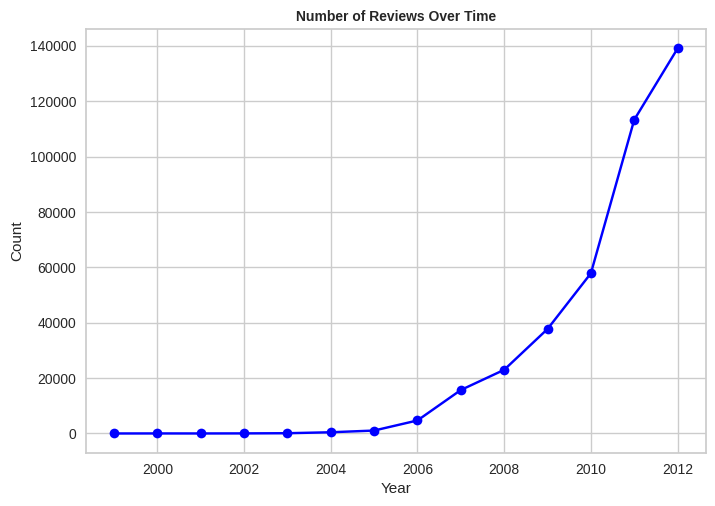

In [14]:
# Grouping the data by year and counting the number of reviews per year
reviews_per_year = reviews["Time"].dt.year.value_counts().sort_index()

plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', color='blue')
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Number of Reviews Over Time', fontweight='bold', fontsize=10)
plt.grid(True)
plt.show()


As we can see from the above line plot, there was an impressive growth in the number of reviews over time. This could be easly explained by the popolarity and frequent use of Amazon gained year by year.

## Dropping Unecessary Columns

As our goal is to analyze text, we decided to drop some of the columns contained in the dataset, since they are not meaningful to our purpose. Specifically, the 'ProductId', 'UserId', 'Time', 'ProfileName' 'HelpfulnessNumerator', 'HelpfulnessDenominator' and 'Summary' are going to be dropped.

Therefore, only the features 'Score' and 'Text' are going to be used.

In [15]:
reviews.drop(['ProductId', 'UserId', 'Time', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator', 'Summary'],
                axis = 1, inplace = True)

reviews.reset_index(drop=True, inplace=True)

reviews.head()

,Score,Text
0,5,Rooibos Natural Red tea is something of a pers...
1,1,I just got this coffee a few days ago. I had c...
2,5,There is nothing else like this on the market....
3,1,I do not like sour taste and this has a sour k...
4,5,For far too long I was a devotee of the Starbu...


--------------------------------------------------------------------------------

# Text Preprocessing

In this section, we'll focus on text preprocessing, a crucial step in preparing raw text data for analysis. By cleaning and standardizing the text, we can reduce noise and inconsistencies, ensuring that our data is in an optimal format for accurate and efficient analysis.

## Normalization

In order to ensure that the subsequent preprocessing steps, like tokenization or stemming, operate on a uniform dataset, preventing variations in capitalization or formatting from introducing errors or inconsistencies in the analysis, we decided to perform normalization as the first step.

Therefore, in this section we deal with lower-casing all capital letters, replacing words with feasible and meaningful abbreviation and, lastly, with removing accents.

As we want to clasify reviews into positive or negative, we decided to keep the word "not" as it plays a crucial role in accurately distinguishing between positive and negative.

In [16]:
# Function to expand common English contractions, focusing on 'not' cases
def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'t": " not",
        "isn't": "is not"
    }
    pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')
    expanded_text = pattern.sub(lambda x: contractions[x.group()], text)
    return expanded_text

# Function to replace accents with normal letters
def replace_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))

# Function to apply all normalization steps
def normalize_text(text):
    # 1. Convert text to lowercase
    text = text.lower()
    # 2. Expand contractions
    text = expand_contractions(text)
    # 3. Replace accents with normal letters
    text = replace_accents(text)
    return text

In [17]:
# Text before normalization
print("Before:")
original_text = reviews.at[1, 'Text']
print(original_text, '\n\n')

# Applying the normalization function to the 'Text' column
reviews['Text'] = reviews['Text'].map(normalize_text)

# Displaying text after normalization
print("After:")
normalized_text = reviews.at[1, 'Text']
print(normalized_text)

Before:
I just got this coffee a few days ago. I had coffee with this bean yesterday and today morning. I can't like this coffee even if I'm trying so hard to like this coffee. 


After:
i just got this coffee a few days ago. i had coffee with this bean yesterday and today morning. i cannot like this coffee even if i'm trying so hard to like this coffee.


### Emojis, URLs, White Spaces, Numbers and Tags
Who has never written an emoji in a review? Or maybe referred to another product for comparison by inserting a URL of that product?



In [18]:
import textwrap

pd.set_option('display.max_colwidth', None)

# Defining patterns for double spaces, URLs, simple emojis, numbers, and tags
patterns = {
    "Double Spaces": r' {2,}',          # Matches two or more consecutive spaces
    "URLs": r'https?://\S+',            # Matches URLs
    "Emojis": r':\)|:\(|;\)',           # Matches simple emojis like :) :( ;)
    "Numbers": r'\b\d+\b',              # Matches standalone numbers
    "Tags": r'#\w+|@\w+'                # Matches hashtags and mentions (e.g., #hashtag, @mention)
}

wrap_width = 200

# Extracting and displaying a few rows for each pattern
for case, pattern in patterns.items():
    matching_rows = reviews[reviews['Text'].str.contains(pattern, regex=True, na=False)].sample(n=3, random_state=1)
    print(f" ......{case}......")

    for idx, text in matching_rows['Text'].items():
        wrapped_text = textwrap.fill(text, width=wrap_width)
        print(f"ID: {idx}")
        print(wrapped_text, '\n')


 ......Double Spaces......
ID: 97325
another 30 lb bag is all gone.  my 9 month old newfoundland puppy just weighed in at 135 pounds.  he seems to like it, no allergies, or digestive upsets with this food.  he eats about 2 bags a month
and i'll be needing to get him a job to help pay for his food soon. 

ID: 197879
this granola has great ingredients and is very tasty.  i need to let it soak in milk for about 5 minutes to make it less challenging to chew (very hard and cruncy, and i'm not all that old...).  the
funny thing about this granola is that it must be very high in fiber, if you know what i mean, so i have to eat it at strategic times.  i ate a bowl before getting on a two-hour airplane ride, and
well, let's just say it made for a rather uncomfortable trip. 

ID: 136677
i remembered this book from my childhood and got it for my kids.  it's just as good as i remembered and my kids love it too.  my older daughter now reads it to her sister.  good rhymes and nice
pictures. 

 .....

People often include emojis, URLs, tags, numbers and double spaces in their reviews to convey emotions, share resources, or emphasize certain points.

However, as our main focus in on textual content, we decided to remove these elements during preprocessing to ensure that the text is accurately interpreted and prepared for analysis.

To do so, by defining a regex we tried to remove all smarphone emojis that we could find and some of emoticons as the reviews time frame goes from 1999 to 2012.

In [19]:
# Defining smartphone emoji pattern
emojis = re.compile("["
      u"\U0001F600-\U0001F64F"  # Emoticons (e.g., grinning face, crying face)
      u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs (e.g., hearts, stars)
      u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols (e.g., cars, trains)
      u"\U0001F700-\U0001F77F"  # Alchemical Symbols
      u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
      u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
      u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
      u"\U0001FA00-\U0001FA6F"  # Chess Symbols, Various Symbols
      u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
      u"\U00002600-\U000026FF"  # Miscellaneous Symbols (e.g., sun, umbrella)
      u"\U0001F1E0-\U0001F1FF"  # Flags (e.g., country flags)
      u"\U00002702-\U000027B0"  # Dingbats
      u"\U0001F926-\U0001F937"  # Gesture emojis
      u"\u200d"                 # Zero width joiner
      u"\u2640-\u2642"          # Gender symbols
      u"\U0001F004-\U0001F251"  # Mahjong tiles, cards
      u"\U0001F018-\U0001F270"  # Dice, dominoes, etc.
      "]+", flags=re.UNICODE)

# Defining emoticons pattern
emoticons = [":(", ":)", ":-(", ":-)", "0:)", "0:-)", "8-)", ':")', ":$", ":'(", ":')",
 ":'-(", ":'-)", ":'-D", ":'D", ":(", ":)", ":*)", ":,'(", ":,'-(", ":,(", ":,)",
 ":,-(", ":,-)", ":,-D", ":,D", ':-")', ":-$", ":-(", ":-)", ":-*", ":-/", ":-@",
 ":-D", ":-o", ":-O", ":-P", ":-S", ":-Z", ":-|", ":/", ":@", ":D", ":o", ":O",
 ":P", ":s", ":z", ":|", ";(", ";)", ";-(", ";-)", "]:)", "]:-)", "B-)", "o:)",
 "O:)", "O:-)", "o:-)", "X-)", "x-)", ": )", ": ("
]


# Combining emoticons regex pattern
emoticons_ = re.compile(r'|'.join(map(re.escape, emoticons)))

# Removing HTML tags
def tags_removal(phrase):
    return re.sub(r"<[^<]+?>", '', phrase)

# Removing URLs
def url_removal(phrase):
    phrase = re.sub(r"http\S+", '', phrase)
    phrase = re.sub(r"www\.[\S]+?it", '', phrase)
    return re.sub(r"www\.[\S]+?com", '', phrase)

# Removinge multiple spaces or tabs
def multi_space_removal(phrase):
    return re.sub("\s\s+", " ", phrase).strip()

# Removing both smartphone emojis and emoticons
def emoij_removal(phrase):
    phrase = emojis.sub('', phrase)
    phrase = emoticons_.sub('', phrase)
    return phrase

# Removing numbers, punctuation, and underscores
def num_removal(phrase):
    phrase = re.sub('[^\w\s]', ' ', phrase)
    phrase = re.sub('\d+', '', phrase)
    return phrase

# Combined
def gen_removal(phrase):
    phrase = tags_removal(phrase)
    phrase = url_removal(phrase)
    phrase = emoij_removal(phrase)
    phrase = num_removal(phrase)
    return multi_space_removal(phrase)


In [20]:
# Reviews ID
id1 = 97325
id2 = 323633
id3 = 166534
id4 = 141517
id5 = 315728


# Printing before cleaning
print(" Before:")
print(f'Example1 (ID {id1}): {reviews.loc[id1]["Text"]}\n')
print(f'Example2 (ID {id2}): {reviews.loc[id2]["Text"]}\n')
print(f'Example3 (ID {id3}): {reviews.loc[id3]["Text"]}\n')
print(f'Example4 (ID {id4}): {reviews.loc[id4]["Text"]}\n')
print(f'Example5 (ID {id5}): {reviews.loc[id5]["Text"]}\n')

# Applying steps
reviews['Text'] = reviews['Text'].apply(gen_removal)

# Printing after cleaning
print("After:")
print(f'Example1 (ID {id1}): {reviews.loc[id1]["Text"]}\n')
print(f'Example2 (ID {id2}): {reviews.loc[id2]["Text"]}\n')
print(f'Example3 (ID {id3}): {reviews.loc[id3]["Text"]}\n')
print(f'Example4 (ID {id4}): {reviews.loc[id4]["Text"]}\n')
print(f'Example5 (ID {id5}): {reviews.loc[id5]["Text"]}\n')


 Before:
Example1 (ID 97325): another 30 lb bag is all gone.  my 9 month old newfoundland puppy just weighed in at 135 pounds.  he seems to like it, no allergies, or digestive upsets with this food.  he eats about 2 bags a month and i'll be needing to get him a job to help pay for his food soon.

Example2 (ID 323633): while clearly distinct from <a href="http://www.amazon.com/gp/product/b000ofnl5c">maynards wine gums roll-pack 4</a>, these are perfectly acceptable wine gums. a little sweeter and a little less chewy, but still a definite tartness to the flavoring and that satisfying solidity that is wholly missing from the gummis and their relatives.

Example3 (ID 166534): this is a really great k-cup cocoa. i had been drinking the cafe express but they have really gone up lately so this is a good buy . nice creamy chocolate flavor so i switched to this. i found it at walmart but this price is better  here for the 3 pack. give it a try :)

Example4 (ID 141517): i love this rice, i cook 

## Stop-Words Removal
Removing stop-words is an essential task to correclty analize text.

For this reason, we decided to remove them by using the nltk packege which provides a list of english stopwords. However, since we are dealing with amazon reviews, we decided to inlcude in this list other words that could be meaningless given the context. Specifically, we included words such as: amazon, shop, product, purchase, cart, kindle.

In [21]:
# Retrieving the list of stopwords
list_stopwords = stopwords.words('english')

# Adding specific words related to Amazon
amazon_related_words = [
    'amazon', 'kindle', 'shop', 'product', 'cart', 'purchase'
]

# Combine the stopwords and Amazon-related words
list_stopwords = list_stopwords + amazon_related_words

# Removing 'not' from the stopwords list
if 'not' in list_stopwords:
    list_stopwords.remove('not')

# Function to remove stopwords from a given phrase
def stopword_removal(phrase, stopwords_list):
    return ' '.join([word for word in phrase.split() if word.lower() not in stopwords_list])

In [22]:
# Printing before cleaning
print(" Before:")
print(f'Example4 (ID {id4}): {reviews.loc[id4]["Text"]}\n')
print(f'Example5 (ID {id5}): {reviews.loc[id5]["Text"]}\n')

# Applying stopwrods remov
reviews['Text'] = reviews['Text'].apply(lambda x: stopword_removal(x, list_stopwords))

# Printing after cleaning
print("After:")
print(f'Example4 (ID {id4}): {reviews.loc[id4]["Text"]}\n')
print(f'Example5 (ID {id5}): {reviews.loc[id5]["Text"]}\n')

 Before:
Example4 (ID 141517): i love this rice i cook it in a rice cooker i found that using at least parts water or parts to one part rice is the way to go add a little sea salt and a little ghee it s great ps wild rice is a seed actually very nutricious

Example5 (ID 315728): i love this and just wish it was sold in bigger packages i like to make it in advance and put it in separate containers to microwaver for lunches at work with added sausage or chicken however at roughly per package retail it only makes a healthy servings even though it s rated for four a bigger package would allow me to buy fewer packages and make several lunches at a time this has an excellent seasoning patina and i love it quickly becoming a staple as the last reviewer mentioned

After:
Example4 (ID 141517): love rice cook rice cooker found using least parts water parts one part rice way go add little sea salt little ghee great ps wild rice seed actually nutricious

Example5 (ID 315728): love wish sold bigger

## Tokenization
To ensure correct preprocessing, text tokenization was therefore perfomed using the word_tokenize function provided in the nltk package.



In [23]:
reviews['Tokens'] = reviews['Text'].apply(word_tokenize)

# Checking results
reviews[['Text', 'Tokens']].head(5)

,Text,Tokens
0,rooibos natural red tea something personal taste interesting flavor things good prefer add little cinnamon mine known used people get gout since incidents since drinking tea works use good tea caffeine free prefer sugar give try calming effect,"[rooibos, natural, red, tea, something, personal, taste, interesting, flavor, things, good, prefer, add, little, cinnamon, mine, known, used, people, get, gout, since, incidents, since, drinking, tea, works, use, good, tea, caffeine, free, prefer, sugar, give, try, calming, effect]"
1,got coffee days ago coffee bean yesterday today morning cannot like coffee even trying hard like coffee,"[got, coffee, days, ago, coffee, bean, yesterday, today, morning, can, not, like, coffee, even, trying, hard, like, coffee]"
2,nothing else like market gmo highest fiber cereal find high protein keeps healthy not eat cereals mostly junk,"[nothing, else, like, market, gmo, highest, fiber, cereal, find, high, protein, keeps, healthy, not, eat, cereals, mostly, junk]"
3,not like sour taste sour kind taste not like smell not great either,"[not, like, sour, taste, sour, kind, taste, not, like, smell, not, great, either]"
4,far long devotee starbucks roast much better rich tasty strong coffee without bitter bite lovely crema works great automatic espresso machine love love love lavazza,"[far, long, devotee, starbucks, roast, much, better, rich, tasty, strong, coffee, without, bitter, bite, lovely, crema, works, great, automatic, espresso, machine, love, love, love, lavazza]"


## Stemming
To reduce variability and increse consistency, we now perform stemming, using the PorterStemmer.

In [24]:
# Initialize the Porter Stemmer
porter = PorterStemmer()

# Defining a function to apply stemming on a list of tokens
def stemming(token_words, stemmer):
    stem_text = [stemmer.stem(word) for word in token_words]
    return stem_text

# Applying stemming to the tokenized text
reviews['Stem_Text'] = reviews['Tokens'].apply(lambda x: stemming(x, porter))

# Checking results
print(reviews.head(5))


   Score  \
0      5   
1      1   
2      5   
3      1   
4      5   

                                                                                                                                                                                                                                                  Text  \
0  rooibos natural red tea something personal taste interesting flavor things good prefer add little cinnamon mine known used people get gout since incidents since drinking tea works use good tea caffeine free prefer sugar give try calming effect   
1                                                                                                                                              got coffee days ago coffee bean yesterday today morning cannot like coffee even trying hard like coffee   
2                                                                                                                                        nothing else like market gmo highest fib

-------------------------------------------------------------------------------

# Data Splitting for Classification
As we decided to perform a binary classification task, i.e., positive (4.5) and negative (1-2) reviews, we must exlude from the data those reviews that have a neutral score, i.e., 3.



In [25]:
reviews_class = reviews[['Score', 'Text', 'Stem_Text']]

# Removing all revies with score = 3
reviews_classes = reviews_class[reviews_class['Score'] != 3]

As second step, we need to convert the positive (4-5) and negative (1-2) scores into two classes, that is.

In [26]:
# Defining the two classes
def classes(x):
  return 1 if x>3 else 0 if x<3 else 2

reviews_classes['Classes'] = reviews_classes['Score'].apply(classes)

reviews_classes[['Score', 'Classes']].head()

<ipython-input-26-9fb1c96e9537>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_classes['Classes'] = reviews_classes['Score'].apply(classes)


,Score,Classes
0,5,1
1,1,0
2,5,1
3,1,0
4,5,1


## Train and Test Sets

In this section we split the data into training and test set, which will later be used to train models.

In [27]:
# splitting data into training and test. We keep 20% of rows as test set
X_train, X_test, Y_train, Y_test = train_test_split(reviews_classes['Stem_Text'],
                                                    reviews_classes['Classes'],
                                                    test_size=0.30,
                                                    random_state=12345,
                                                    stratify=reviews_classes['Classes'])

-------------------------------------------------------------------------------

# Unbalanced Score

We have now cleaned and preprocessed the reviews; however, we did not check whether the reviews are balanced in score or not.

We check the score of the original review dataset and see whether there is a difference in the training set after preprocessing and splitting.

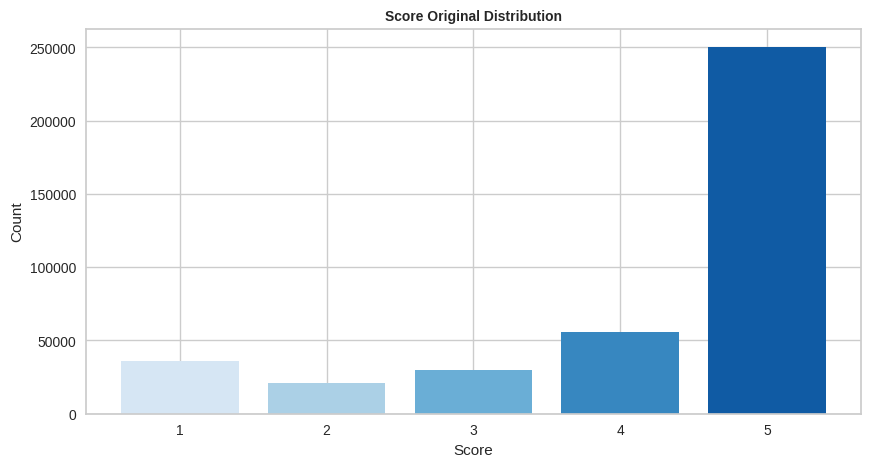

In [28]:
# Calculating the count of each score
score_counts = reviews['Score'].value_counts().sort_index()

# Plotting the rating score distribution using a bar plot
plt.figure(figsize=(10, 5))
plt.bar(score_counts.index, score_counts.values, color=sns.color_palette("Blues", 5))

plt.title("Score Original Distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

<ipython-input-29-785381158756>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))
<ipython-input-29-785381158756>:2: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))


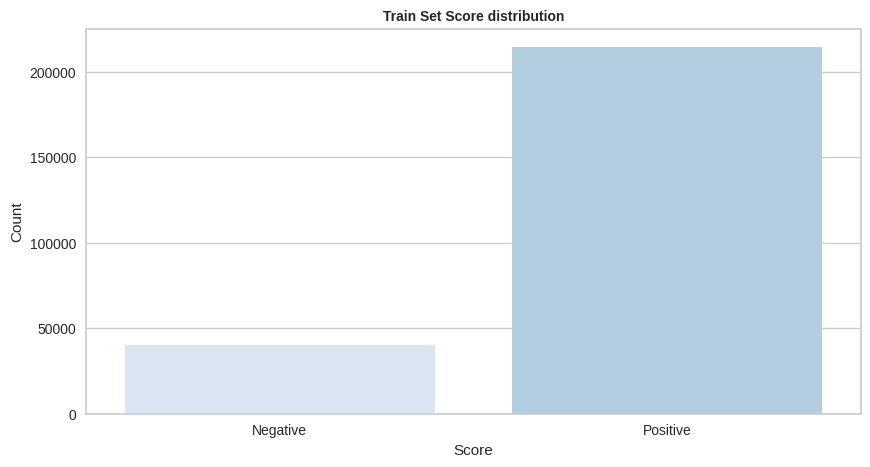

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))

plt.title("Train Set Score distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(np.arange(0,2,1), ['Negative', 'Positive'])
plt.show();

As we can see, the reviews' score was unbalanced before preprocessing and it is still after.

Therefore, we proceeded by downsampling the dominant class, i.e., the positive class, as the amount of data is still significant.

In [30]:
training = pd.concat([X_train, Y_train], axis = 1)

# Extracting sample for each class
neg = training.loc[training['Classes'] == 0]
pos = training.loc[training['Classes'] == 1].sample(neg.shape[0], random_state = 123)

data = pd.concat([pos, neg])
data = shuffle(data, random_state = 1234)

X_train = data['Stem_Text']
Y_train = data['Classes']

<ipython-input-31-0d8fee48a32d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))
<ipython-input-31-0d8fee48a32d>:3: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))


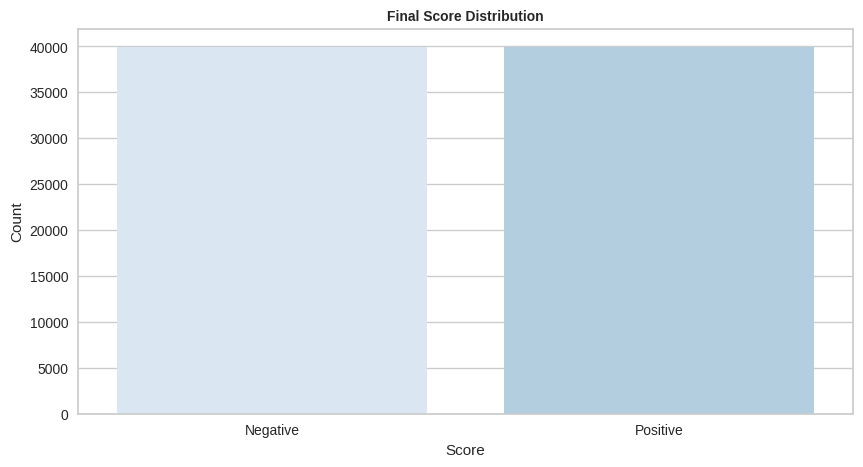

In [31]:
# Checking classes again
plt.figure(figsize=(10,5))
sns.countplot(x = Y_train, palette=sns.color_palette("Blues", 5))

plt.title("Final Score Distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(np.arange(0,2,1), ['Negative', 'Positive'])
plt.show();

-------------------------------------------------------------------------------

# Text Representation
As we have already tokenized our data, in this section we proceed with text representation.

Before doing that, we check the lenght of the reviews in order to decide which could be the most appropriate techniques to represent text.



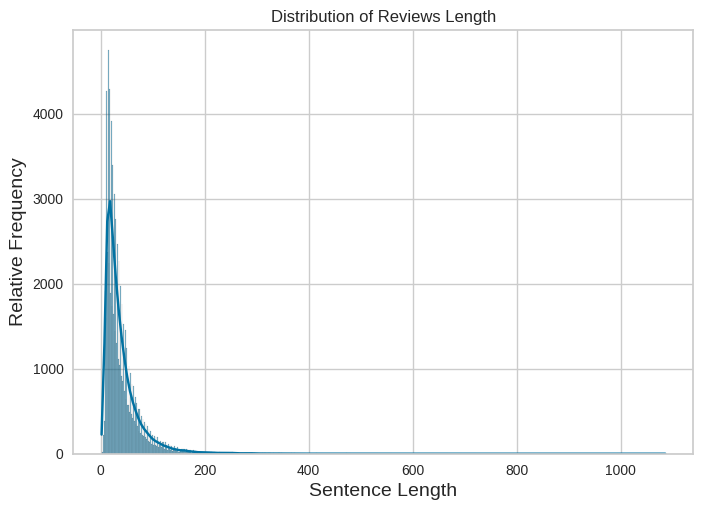

In [32]:
# Calculating the lengths of sentences in the training data
sentence_lengths = [len(s) for s in X_train]

# Creating a distribution plot
sns.histplot(sentence_lengths, kde=True)

plt.title('Distribution of Reviews Length')
plt.ylabel("Relative Frequency", size=14)
plt.xlabel("Sentence Length", size=14)
plt.show()

As we can see from the above plot, the difference in reviews length is not wide. We can therefore proceed by applying two techniques.

## BoW

We do so by first applying a simple representation where the text is represented as an unordered collection of words, without considering grammar or word order, i.e., Bag of Words (BoW), by counting the single occurances.

We therefore proceed by applying BoW on the train set first.


In [33]:
# BoW on Training set
BoW = CountVectorizer(min_df = 7).fit(X_train.astype(str))

As we applied BoW, we now expect to observe the matrix becoming sparse. As we are dealing with reviews, this sparsity occurs as each individual review cannot contain every word from the entire vocabulary.

In [34]:
# Applying transformation
X_train_BoW = BoW.transform(X_train.astype(str))

print('BoW matrix min. value:', X_train_BoW.min())
print('BoW matrix max. value:', X_train_BoW.max())

BoW matrix min. value: 0
BoW matrix max. value: 71


In [35]:
X_train_BoW

<79858x9697 sparse matrix of type '<class 'numpy.int64'>'
	with 2543792 stored elements in Compressed Sparse Row format>

We can observe a Max. Value that is close to 1, but is not 1. However, this is somewhat justified as we chose to count the occurances.

We now apply BoW to the test set.

In [36]:
# Applying same bow trasformation to test set
X_test_BoW = BoW.transform(X_test.astype(str))

X_test_BoW

<108974x9697 sparse matrix of type '<class 'numpy.int64'>'
	with 3390852 stored elements in Compressed Sparse Row format>

## TF-IDF
In order to compare the performance across different text representation techniques, we decided to also apply TF-IDF, a more advanced representation that reflects how important a word is to a document in a collection of documents.

We therefore proceed by applying Tf-Idf on the train set first.


In [37]:
tfidf = TfidfVectorizer(min_df = 7).fit(X_train.astype(str))

As in the case of BoW, we now expect to observe the matrix becoming sparse.

In [38]:
# Applying transformation
X_train_tfidf = tfidf.transform(X_train.astype(str))

X_train_tfidf

<79858x9697 sparse matrix of type '<class 'numpy.float64'>'
	with 2543792 stored elements in Compressed Sparse Row format>

In [39]:
print('TF-IDF matrix min. value:', X_train_tfidf.min())
print('TF-IDF matrix max. value:', X_train_tfidf.max())

TF-IDF matrix min. value: 0.0
TF-IDF matrix max. value: 1.0


We observe that, compared to the BoW, the maximum value of the TF-IDF is 1.

We now apply TF-IDF to the test set.

In [40]:
# Applying transformation
X_test_tfidf = tfidf.transform(X_test.astype(str))

X_test_tfidf

<108974x9697 sparse matrix of type '<class 'numpy.float64'>'
	with 3390852 stored elements in Compressed Sparse Row format>

# Reducing Dimensionality
The text representations generated using Bag of Words and TF-IDF methods result in a large number of features, demanding significant computational resources and time for classification and clustering tasks. To address this, we decided to apply a technique that is particularly well-suited for working with sparse matrices, that is, Truncated SVD, on both BoW and TF-IDF.

The aim is of course trying to retain the most variance.

In [41]:
# Trunc. SVD on BoW
T_SVD_BoW = TruncatedSVD(n_components=700).fit(X_train_BoW)

print('BoW explained variance:', T_SVD_BoW.explained_variance_ratio_.sum())

BoW explained variance: 0.7877560628874274


As the variance explained amounts to 78%, we therefore proceed to apply the transformation.

In [42]:
# Applying Trunc. SVD to X_train
X_train_BoW = T_SVD_BoW.transform(X_train_BoW)

We repeat the same steps for TF-IDF

In [43]:
# Trunc. SVD on TF-IDF
T_SVD_tfidf = TruncatedSVD(n_components=1500).fit(X_train_tfidf)

print('Tf-Idf explained variance:', T_SVD_tfidf.explained_variance_ratio_.sum())

Tf-Idf explained variance: 0.7478874129380223


In [44]:
# Applying Trunc. SVD to X_train
X_train_tfidf = T_SVD_tfidf.transform(X_train_tfidf)

We apply the same dimensionality reduction to the test set, for both BoW and TF-IDF

In [45]:
# Applying same dimensionality reduction to test set
X_test_BoW = T_SVD_BoW.transform(X_test_BoW)


In [46]:
#  Applying same dimensionality reduction to test set
X_test_tfidf = T_SVD_tfidf.transform(X_test_tfidf)

--------------------------------------------------------------------------------

# Classifying Reviews
As established in the introduction, we aim to classify reviews into positive or negative, according to their score, which have been transformed into classes.

For this task, we decided to use three different classification approaches.

In [47]:
# Defining useful functions for evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Function to evaluate and display model performance
def evaluate_model_performance(classifier, X_features, y_true_labels, target_names=['Negative', 'Positive']):
    predicted_labels = classifier.predict(X_features)
    predicted_labels = np.round(predicted_labels)

    print(classification_report(y_true_labels, predicted_labels, target_names=target_names))

    cm = confusion_matrix(y_true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False)

    plt.xticks(ticks=[0.5, 1.5], labels=target_names)
    plt.yticks(ticks=[0.5, 1.5], labels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return predicted_labels

# Function to plot the ROC curve and calculate AUC
def plot_roc_curve(classifier, X_data, y_true):
    predicted_probabilities = classifier.predict_proba(X_data)[:, 1]

    fpr, tpr, _ = roc_curve(y_true, predicted_probabilities)

    auc_score = roc_auc_score(y_true, predicted_probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Function to display the top informative features for each class
def top_informative_features(vectorizer, classifier, num_features=10):
    feature_names = vectorizer.get_feature_names_out()
    feature_coefficients = sorted(zip(classifier.coef_[0], feature_names))

    for (coef_neg, feature_neg), (coef_pos, feature_pos) in zip(feature_coefficients[:num_features], feature_coefficients[-num_features:]):
        print(f"{coef_neg:.4f}\t{feature_neg:20}\t{coef_pos:.4f}\t{feature_pos:20}")


## Light GBM
We therefore apply the LightGMB classifier to the BoW and TF-IDF.

### BoW

In [48]:
lgbm_bow = lgb.LGBMClassifier()
lgbm_bow = lgbm_bow.fit(X_train_BoW, Y_train)

[LightGBM] [Info] Number of positive: 39929, number of negative: 39929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.564508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178500
[LightGBM] [Info] Number of data points in the train set: 79858, number of used features: 700
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


We therefore evaluate the performance on the training set.

              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85     39929
    Positive       0.85      0.84      0.85     39929

    accuracy                           0.85     79858
   macro avg       0.85      0.85      0.85     79858
weighted avg       0.85      0.85      0.85     79858



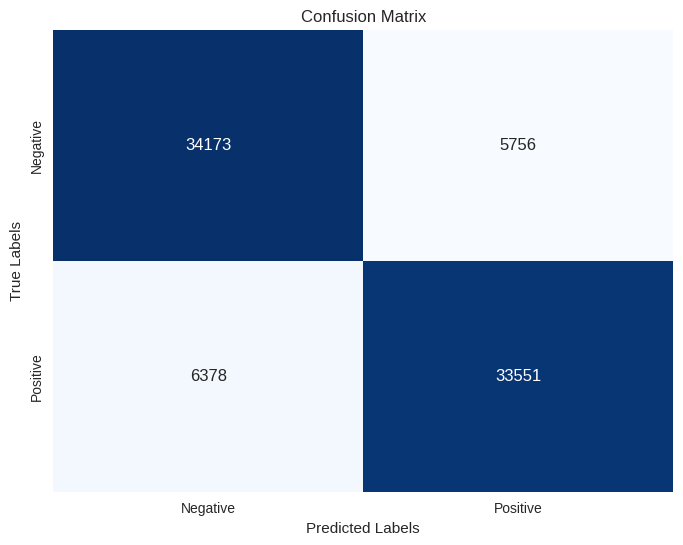

In [49]:
perf_lgbm_bow = evaluate_model_performance(lgbm_bow, X_train_BoW, Y_train)

Performance evaluation on the test set.

              precision    recall  f1-score   support

    Negative       0.43      0.82      0.57     17112
    Positive       0.96      0.80      0.87     91862

    accuracy                           0.80    108974
   macro avg       0.70      0.81      0.72    108974
weighted avg       0.88      0.80      0.82    108974



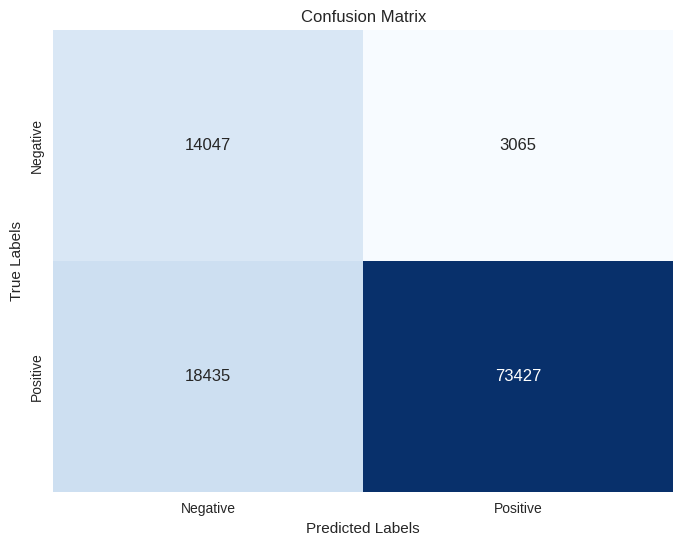

In [50]:
# evaluation metrics on TEST set
y_pred_lgbm_bow = evaluate_model_performance(lgbm_bow, X_test_BoW, Y_test)

It can be seen the the model does not generalized well on unseen data. It struggles with correclty classifying negative reviews.

### TF-IDF

In [51]:
lgbm_tfidf = lgb.LGBMClassifier()
lgbm_tfidf = lgbm_tfidf.fit(X_train_tfidf, Y_train)

[LightGBM] [Info] Number of positive: 39929, number of negative: 39929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.612056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382500
[LightGBM] [Info] Number of data points in the train set: 79858, number of used features: 1500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87     39929
    Positive       0.88      0.85      0.86     39929

    accuracy                           0.87     79858
   macro avg       0.87      0.87      0.87     79858
weighted avg       0.87      0.87      0.87     79858



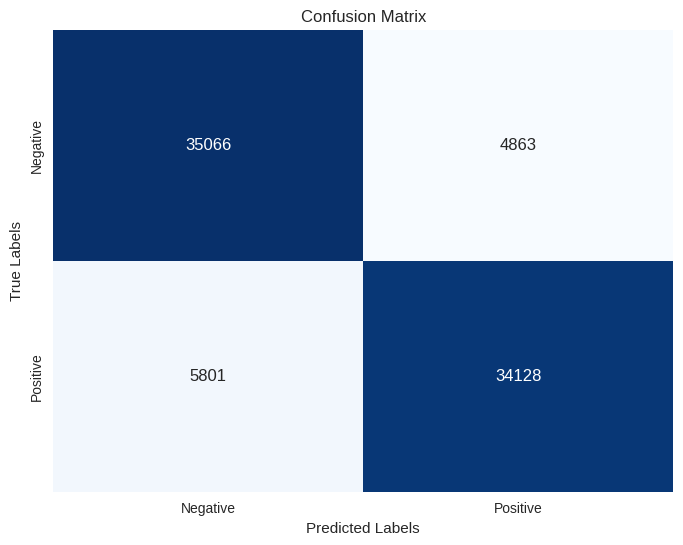

In [52]:
# Evaluation on training set
perf_lgmb_tfidf= evaluate_model_performance(lgbm_tfidf, X_train_tfidf, Y_train)

              precision    recall  f1-score   support

    Negative       0.47      0.85      0.61     17112
    Positive       0.97      0.82      0.89     91862

    accuracy                           0.83    108974
   macro avg       0.72      0.84      0.75    108974
weighted avg       0.89      0.83      0.85    108974



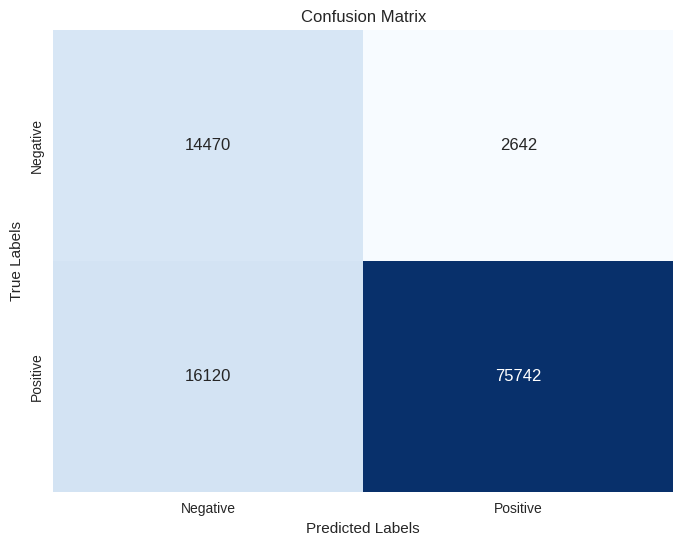

In [53]:
# Evaluation on test set
y_pred_lgbm_tfidf = evaluate_model_performance(lgbm_tfidf, X_test_tfidf, Y_test)

Also in this case, even if the performance is slightly better, the model cannot correctly classify negative reviews.

## Logistic Regression

As the Light GBM shows good results on the train set, but questionable ones on the test set, we decided to proceed with testing another classification method based on logistic regression.

### BoW

To so, we perform in on BoW as previously done.

In [54]:
logreg_bow = LogisticRegression()
logreg_bow = logreg_bow.fit(X_train_BoW, Y_train)

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     39929
    Positive       0.87      0.88      0.87     39929

    accuracy                           0.87     79858
   macro avg       0.87      0.87      0.87     79858
weighted avg       0.87      0.87      0.87     79858



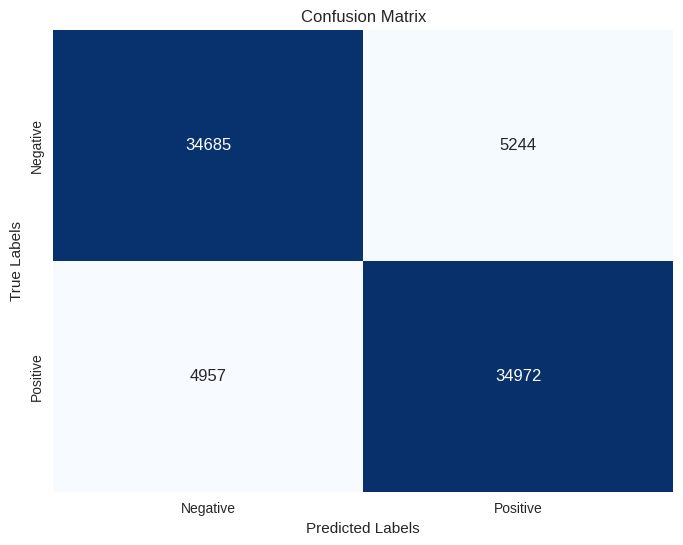

In [55]:
# Evaluation on training set
perf_logreg_bow = evaluate_model_performance(logreg_bow, X_train_BoW, Y_train)

              precision    recall  f1-score   support

    Negative       0.55      0.86      0.67     17112
    Positive       0.97      0.87      0.92     91862

    accuracy                           0.87    108974
   macro avg       0.76      0.87      0.80    108974
weighted avg       0.91      0.87      0.88    108974



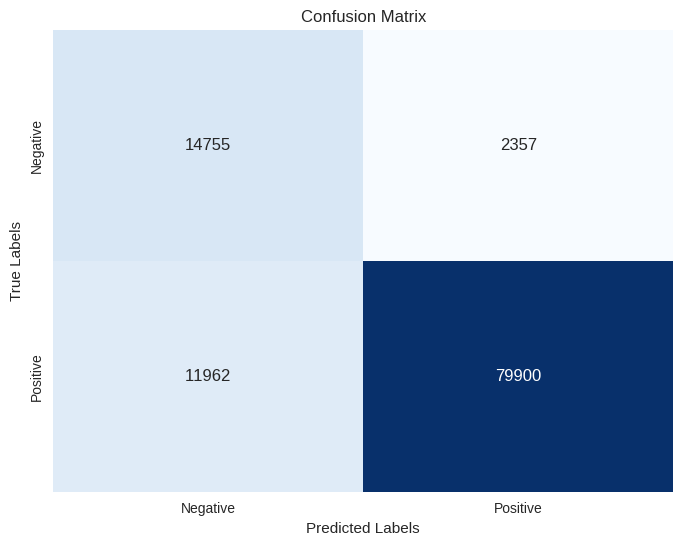

In [56]:
# Evaluation on test set
y_pred_logreg_bow = evaluate_model_performance(logreg_bow, X_test_BoW, Y_test)

We now have a look at the most informative features.

In [57]:
top_informative_features(BoW, logreg_bow)

-2.1347	absent              	1.0292	arrowroot           
-1.8907	absolutley          	1.0340	across              
-1.5442	artifici            	1.0822	barri               
-1.4799	bam                 	1.0829	airborn             
-1.3432	ahead               	1.1011	ace                 
-1.2216	afraid              	1.1041	artisan             
-1.0164	avoid               	1.1313	advisor             
-0.9734	affirm              	1.1479	accordingli         
-0.9671	ador                	1.2997	array               
-0.9558	amaranth            	1.5699	adequ               


### TF-IDF
We now perform the same on the TF-IDF.

In [58]:
logreg_tfidf = LogisticRegression()
logreg_tfidf = logreg_tfidf.fit(X_train_tfidf, Y_train)

              precision    recall  f1-score   support

    Negative       0.88      0.89      0.89     39929
    Positive       0.89      0.88      0.89     39929

    accuracy                           0.89     79858
   macro avg       0.89      0.89      0.89     79858
weighted avg       0.89      0.89      0.89     79858



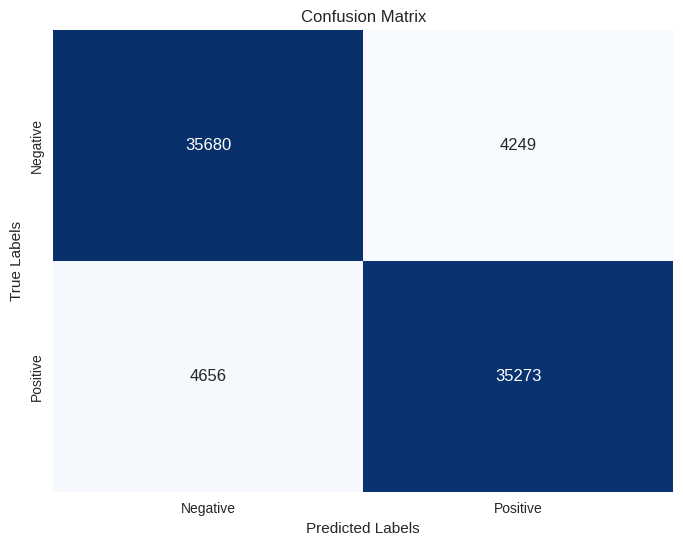

In [59]:
# Evaluation on training set
perf_logreg_tfidf = evaluate_model_performance(logreg_tfidf, X_train_tfidf, Y_train)

              precision    recall  f1-score   support

    Negative       0.57      0.88      0.70     17112
    Positive       0.98      0.88      0.92     91862

    accuracy                           0.88    108974
   macro avg       0.78      0.88      0.81    108974
weighted avg       0.91      0.88      0.89    108974



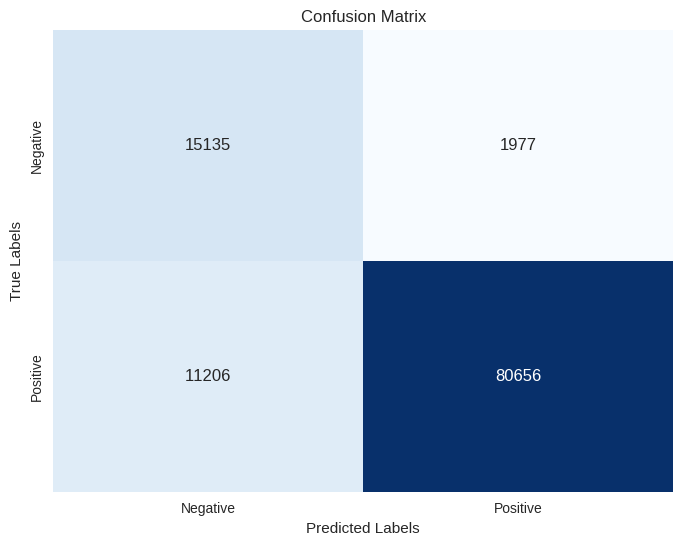

In [60]:
# Evaluation on test set
y_pred_logreg_tfidf = evaluate_model_performance(logreg_tfidf, X_test_tfidf, Y_test)

We now have a look at the most informative features.

In [61]:
top_informative_features(tfidf, logreg_tfidf)

-7.6658	add                 	5.5225	accident            
-7.2668	adher               	5.8845	absolutli           
-7.0659	accomod             	6.1229	ailment             
-6.5829	accompani           	6.1857	acv                 
-5.7862	acquir              	6.7309	acclim              
-5.6074	acidi               	7.4537	absurdli            
-5.5627	aerogrow            	7.9914	absolutley          
-5.4811	age                 	8.0165	accent              
-5.3615	ad                  	10.6002	acceler             
-5.2717	achiev              	36.2087	abdomin             


The logistic regression model actually performs slightly better compared to the LightGBM classifier, also in this case the best text representation is the one given by TF-IDF. However, the model still does not generalize well.

## N-Grams Logistic Regression
Another approach was therefore decided. To exploit the possibility of not analyzing not just single words, but rather pair of words (which could be crucial for binary classficiation if we think about pairs such as "very good" or "not good"), we decided to perform logistic regression but with the N-Grams approach. Also in this case the text representation chosen is TF-IDF.

In [62]:
user_vars = {k: v for k, v in globals().items() if not k.startswith('__') and not callable(v)}

print(list(user_vars.keys()))

['_ih', '_oh', '_dh', 'In', 'Out', '_', '_i', '_ii', '_iii', '_i1', '_exit_code', '_i2', '_i3', 'pd', 'np', 'plt', 'sns', 're', 'unicodedata', 'nltk', 'stopwords', 'metrics', 'lgb', 'preprocessing', 'math', '_i4', 'drive', 'drive_path', '_i5', 'reviews', '_5', '_i6', '_i7', 'first_rev_date', 'last_rev_date', '_i8', 'total_rows', '_i9', 'user_product_counts', 'users_diff_products', 'reviews_diff_products', '_i10', '_10', '_i11', 'total_rev', 'remaining_rev', 'removed_rev', '_i12', 'missing_values', 'missing_values_df', '_i13', '_13', '_i14', 'reviews_per_year', '_i15', '_15', '_i16', '_i17', 'original_text', 'normalized_text', '_i18', 'textwrap', 'patterns', 'wrap_width', 'case', 'pattern', 'matching_rows', 'idx', 'text', 'wrapped_text', '_i19', 'emojis', 'emoticons', 'emoticons_', '_i20', 'id1', 'id2', 'id3', 'id4', 'id5', '_i21', 'list_stopwords', 'amazon_related_words', '_i22', '_i23', '_23', '_i24', 'porter', '_i25', 'reviews_class', 'reviews_classes', '_i26', '_26', '_i27', 'X_trai

In [63]:
del reviews_class, reviews_classes, perf_lgbm_bow,y_pred_lgbm_bow, perf_lgmb_tfidf, y_pred_lgbm_tfidf, perf_logreg_bow, perf_logreg_tfidf

### TF-IDF

In [64]:
# TF-IDF for n-grams
ngrams_tfidf = TfidfVectorizer(min_df = 7, ngram_range = (1,2)).fit(X_train.astype(str))

# Applying transformation
X_train_ngrams_tfidf = ngrams_tfidf.transform(X_train.astype(str))

X_train_ngrams_tfidf

<79858x74101 sparse matrix of type '<class 'numpy.float64'>'
	with 4074045 stored elements in Compressed Sparse Row format>

As done previously, we perfom dimensionality reduction in this case as well, both on the train and the test set.

### SVD

In [65]:
# Trunc. SVD on training set
T_SVD_ngrams = TruncatedSVD(n_components=1500).fit(X_train_ngrams_tfidf)

print('TF-IDF bigrams explained variance:', T_SVD_ngrams.explained_variance_ratio_.sum())

# Applying SVD to X_train
X_train_ngrams_tfidf = T_SVD_ngrams.transform(X_train_ngrams_tfidf)

TF-IDF bigrams explained variance: 0.3782078324965039


In [66]:
# Applying same trasformation to test set
X_test_ngrams_tfidf = ngrams_tfidf.transform(X_test.astype(str))
# Applying same dimensionality reduction to test set
X_test_ngrams_tfidf = T_SVD_ngrams.transform(X_test_ngrams_tfidf)

### Logistic Regression

In [67]:
logreg_ngrams_tfidf = LogisticRegression(max_iter=200)
logreg_ngrams_tfidf = logreg_ngrams_tfidf.fit(X_train_ngrams_tfidf, Y_train)

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90     39929
    Positive       0.90      0.90      0.90     39929

    accuracy                           0.90     79858
   macro avg       0.90      0.90      0.90     79858
weighted avg       0.90      0.90      0.90     79858



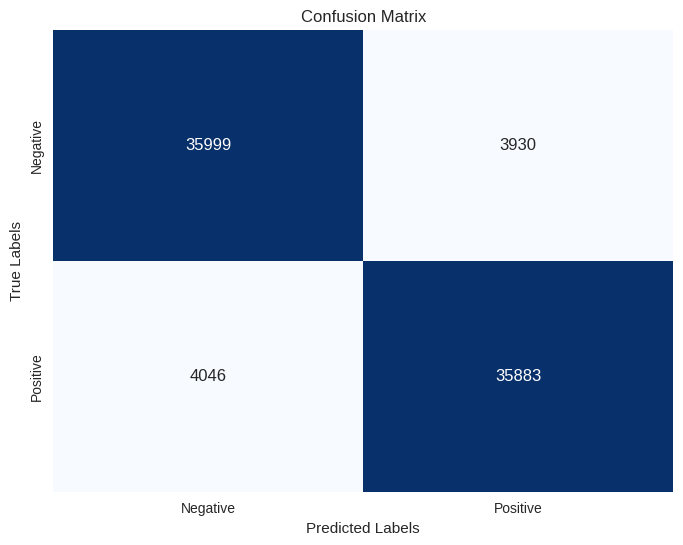

In [68]:
# Evaluation on training set
perf_ngrams_logreg_tfidf = evaluate_model_performance(logreg_ngrams_tfidf, X_train_ngrams_tfidf, Y_train)

              precision    recall  f1-score   support

    Negative       0.61      0.89      0.72     17112
    Positive       0.98      0.89      0.93     91862

    accuracy                           0.89    108974
   macro avg       0.79      0.89      0.83    108974
weighted avg       0.92      0.89      0.90    108974



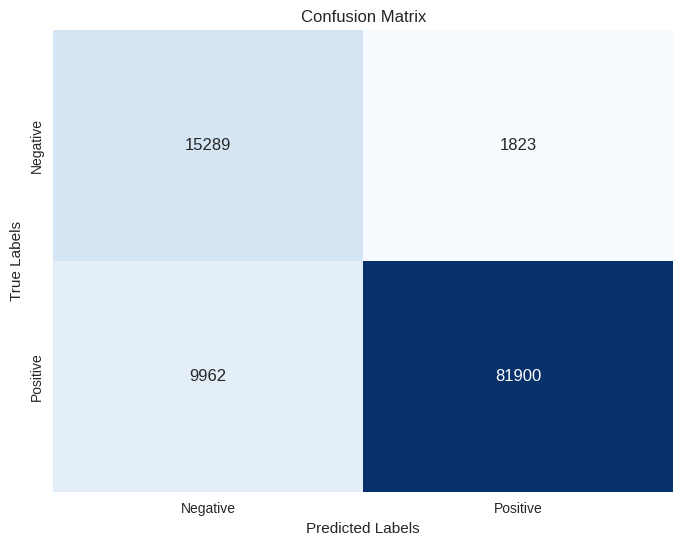

In [69]:
# Evaluation on test set
y_pred_ngrams_logreg_tfidf = evaluate_model_performance(logreg_ngrams_tfidf, X_test_ngrams_tfidf, Y_test)

As we can see, the model is the one that performs better among the others. Also in this case there is a struggle when dealing with negative reviews. Hoever, the performance seems to be acceptable.

We now have a look at the most informative features.

In [70]:
top_informative_features(ngrams_tfidf, logreg_ngrams_tfidf)

-10.7205	abil                	6.4127	abl feed            
-9.7398	abl fall            	6.4588	abl drink           
-8.0085	absolut terribl     	7.0038	absurdli            
-7.0144	abl go              	7.2255	absolut tast        
-6.9371	aberr               	7.2452	acai pomegran       
-6.8578	abl chew            	8.2899	absolut ridicul     
-6.8499	abl find            	8.8334	absorb water        
-6.7754	abdomin cramp       	12.9972	abl locat           
-6.6857	abl return          	13.8365	abl choos           
-6.5416	abl tast            	46.6515	abdomin             


In [71]:
# removing all remaining classification variables for saving memory
del X_test_ngrams_tfidf, X_train_ngrams_tfidf, ngrams_tfidf, T_SVD_ngrams,
del perf_ngrams_logreg_tfidf, y_pred_ngrams_logreg_tfidf

# Clustering
The second task we aim to perform is clustering. Similar to our previous approach, we will experiment with various clustering techniques using the TF-IDF representation, as it turned out to be the best one.

A first step we aim to take is standardization, as it ensures that the clustering algorithms treat each feature with equal importance, resulting in more meaningful and accurate clusters.

In [72]:
reviews.head()

,Score,Text,Tokens,Stem_Text
0,5,rooibos natural red tea something personal taste interesting flavor things good prefer add little cinnamon mine known used people get gout since incidents since drinking tea works use good tea caffeine free prefer sugar give try calming effect,"[rooibos, natural, red, tea, something, personal, taste, interesting, flavor, things, good, prefer, add, little, cinnamon, mine, known, used, people, get, gout, since, incidents, since, drinking, tea, works, use, good, tea, caffeine, free, prefer, sugar, give, try, calming, effect]","[rooibo, natur, red, tea, someth, person, tast, interest, flavor, thing, good, prefer, add, littl, cinnamon, mine, known, use, peopl, get, gout, sinc, incid, sinc, drink, tea, work, use, good, tea, caffein, free, prefer, sugar, give, tri, calm, effect]"
1,1,got coffee days ago coffee bean yesterday today morning cannot like coffee even trying hard like coffee,"[got, coffee, days, ago, coffee, bean, yesterday, today, morning, can, not, like, coffee, even, trying, hard, like, coffee]","[got, coffe, day, ago, coffe, bean, yesterday, today, morn, can, not, like, coffe, even, tri, hard, like, coffe]"
2,5,nothing else like market gmo highest fiber cereal find high protein keeps healthy not eat cereals mostly junk,"[nothing, else, like, market, gmo, highest, fiber, cereal, find, high, protein, keeps, healthy, not, eat, cereals, mostly, junk]","[noth, els, like, market, gmo, highest, fiber, cereal, find, high, protein, keep, healthi, not, eat, cereal, mostli, junk]"
3,1,not like sour taste sour kind taste not like smell not great either,"[not, like, sour, taste, sour, kind, taste, not, like, smell, not, great, either]","[not, like, sour, tast, sour, kind, tast, not, like, smell, not, great, either]"
4,5,far long devotee starbucks roast much better rich tasty strong coffee without bitter bite lovely crema works great automatic espresso machine love love love lavazza,"[far, long, devotee, starbucks, roast, much, better, rich, tasty, strong, coffee, without, bitter, bite, lovely, crema, works, great, automatic, espresso, machine, love, love, love, lavazza]","[far, long, devote, starbuck, roast, much, better, rich, tasti, strong, coffe, without, bitter, bite, love, crema, work, great, automat, espresso, machin, love, love, love, lavazza]"


As we need the score column to be in its original scale, we now split the data to somehow ensure the stability and performance of clustering result.

In [73]:
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(reviews['Stem_Text'],
                                                    reviews['Score'],
                                                    test_size=0.30,
                                                    random_state=12345,
                                                    stratify=reviews['Score'])

### TF-IDF + Reducing Dimensionality

In [74]:
# TF-IDF
c_tfidf = TfidfVectorizer(min_df = 5).fit(X_train_c.astype(str))
# Applying transformation
X_train_tfidf = c_tfidf.transform(X_train_c.astype(str))

In [75]:
# Trunc. SVD on tfidf
trunc_svd_tfidf = TruncatedSVD(n_components=1500).fit(X_train_tfidf)

print('Tf-Idf explained variance:', trunc_svd_tfidf.explained_variance_ratio_.sum())

# Applying SVD to X_train
X_train_tfidf = trunc_svd_tfidf.transform(X_train_tfidf)

Tf-Idf explained variance: 0.7256269044866885


#### Normalization

In [76]:
X_stand_train = preprocessing.normalize(X_train_tfidf)

In [77]:
# Some useful functions

def plot_cluster_wordclouds(text_data, cluster_labels, num_clusters, ncols=4):
    rows = math.ceil(num_clusters / ncols)

    fig, axs = plt.subplots(rows, ncols, figsize=(20, rows * 5))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    axs = axs.flatten()

    for i in range(num_clusters):
        cluster_text = " ".join(np.array(text_data)[np.array(cluster_labels) == i])

        # Generating word cloud for the cluster
        wordcloud = WordCloud(background_color="white").generate(cluster_text)

        # Plotting the word cloud
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].set_title(f"Cluster {i} Word Cloud")
        axs[i].axis("off")


    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.show()


In [78]:
def cluster_wordclouds(data, n_cluster, ncols = 4):
  nrows = math.ceil(n_cluster/ncols)

  fig = plt.figure(figsize =(25,30))
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.4, wspace=0.2, hspace=0.2)

  # Plot wordcloud for each cluster
  for i in range(0,n_cluster,1):
    plt.subplot(nrows, ncols, 1+i)

    text = " ".join(str(t) for t in np.where(data[1] == i, data[0], ''))
    text = text.replace("'", "")

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate_from_text(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    tit = 'Wordcloud of cluster: ' + str(i)
    plt.title(tit)
    plt.axis("off")

In [79]:
from sklearn.metrics import (rand_score, adjusted_mutual_info_score, homogeneity_score,
                             completeness_score, v_measure_score, fowlkes_mallows_score, silhouette_score)

def clustering_performance(true_labels, predicted_labels, feature_matrix):
    metrics = {
        "Rand Index": rand_score(true_labels, predicted_labels),
        "Homogeneity Score": homogeneity_score(true_labels, predicted_labels),
        "Completeness Score": completeness_score(true_labels, predicted_labels),
        "V-Measure": v_measure_score(true_labels, predicted_labels),
        "Silhouette Score": silhouette_score(feature_matrix, predicted_labels)
    }

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name:25}: {metric_value:.4f}")


## Natural Score Structure
Here we want to see whether it is possible to visualize a pattern in the reviews based on their score.

We do so by visualizing the available reviews in a two-dimensional space. We will employ t-SNE to reduce the high-dimensional feature set extracted from TF-IDF to two dimensions and visualize the results to gain insights into potential clustering patterns.

Due to computational constraints, the dimensionality reduction will be performed on a subset of 700 reviews. While this subset may not fully represent the entire dataset, it will provide a general understanding of the reviews' spatial distribution.

In [80]:
# Performing t-SNE to reduce data to 2D
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
data_2d = tsne.fit_transform(X_stand_train[:700])

x_values = data_2d[:, 0]
y_values = data_2d[:, 1]

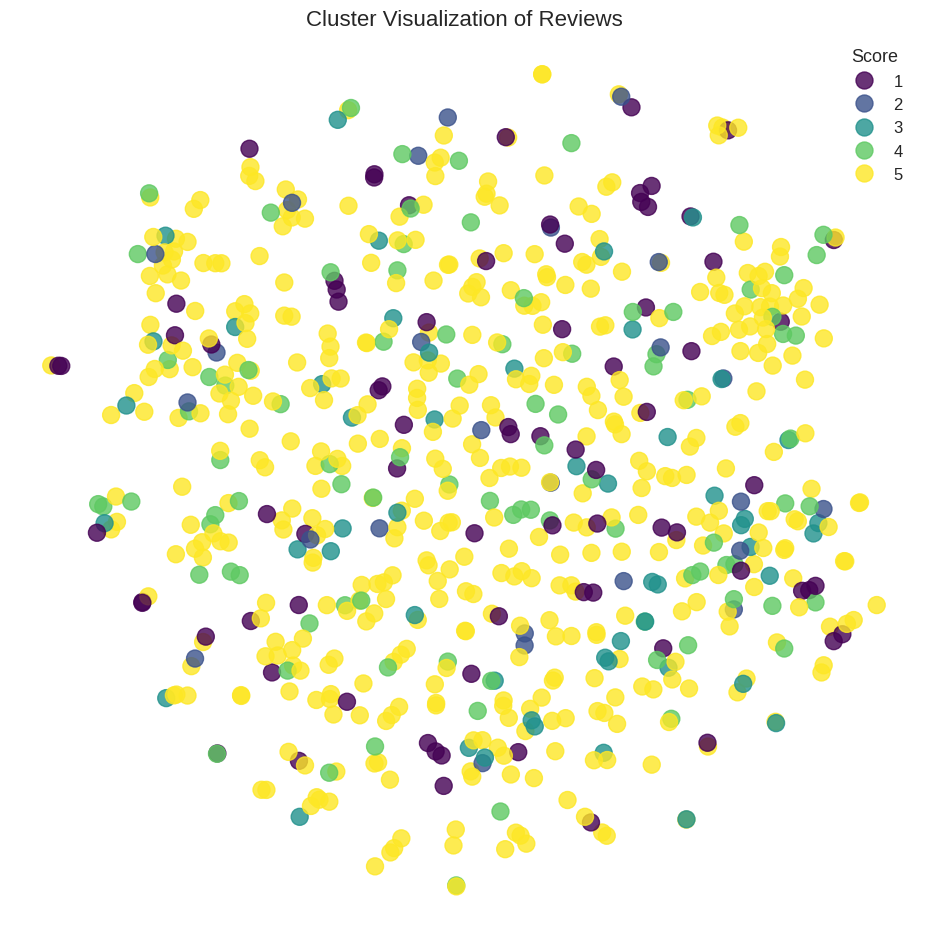

In [81]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=x_values,
    y=y_values,
    hue=Y_train_c[:700],
    s=150,
    palette='viridis',
    alpha=0.8,
    edgecolor=None
)


plt.title('Cluster Visualization of Reviews', fontsize=16)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.legend(title='Score', title_fontsize='13', loc='upper right', fontsize='12')
plt.tight_layout()
plt.axis('off')
plt.show()

Lookint at the above scatter plot it is possible to see that there is no clear clustering structure based on score, suggesting that that many reviews, despite having different ratings, share similar characteristics or sentiments.

Given the results obtained from visualizing the structure of the reviews, we will now be analyzing and evaluating the clustering with respect to the review scores. Subsequently, we will assess the semantic content and distribution within each cluster to identify the optimal number of clusters.

## Agglomerative Hierarchical Clustering

In [82]:
ahc = AgglomerativeClustering(n_clusters=5).fit(X_stand_train[:7000])

In [83]:
ahcc = Counter(ahc.labels_)

# N. of elements per cluster
for i in range(0, ahc.n_clusters, 1):
  print('N. of reviews in Cluster ' + str(i) + ': ' + str(ahcc[i]))

N. of reviews in Cluster 0: 452
N. of reviews in Cluster 1: 5413
N. of reviews in Cluster 2: 602
N. of reviews in Cluster 3: 302
N. of reviews in Cluster 4: 231


In [84]:
# Cluster performance
clustering_performance(Y_train_c[:7000], ahc.labels_, X_stand_train[:7000])

Rand Index               : 0.4830
Homogeneity Score        : 0.0021
Completeness Score       : 0.0029
V-Measure                : 0.0025
Silhouette Score         : 0.0040


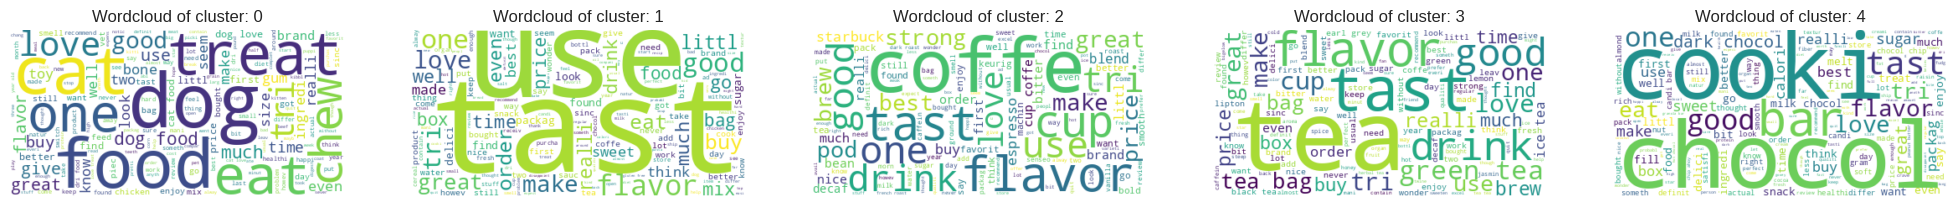

In [85]:
cluster_wordclouds([X_train_c[:7000], ahc.labels_], ahc.n_clusters, ncols = 5)

The agglomerative clustering results indicate that the algorithm primarily grouped reviews based on content (such as dog food, coffee, and chocolate) rather than by their scores. The evaluation metrics indicate poor performance.

## K-Means
As mentioned earlier, we will now try to see whether reviews having the same score actually form their distinc cluster, using the K-Means algorithm.

In [86]:
kmeans = KMeans(n_clusters=5, random_state=12345).fit(X_stand_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We now see how many reviews per cluster were found.

In [87]:
c = Counter(kmeans.labels_)

for i in range(0,kmeans.n_clusters, 1):
  print('N. of reviews in Cluster ' + str(i) + ': ' + str(c[i]))

N. of reviews in Cluster 0: 18315
N. of reviews in Cluster 1: 23386
N. of reviews in Cluster 2: 22260
N. of reviews in Cluster 3: 190953
N. of reviews in Cluster 4: 20164


We evaluate the clustering performance through the function previously defined.

In [88]:
clustering_performance(Y_train_c, kmeans.labels_, X_stand_train)

Rand Index               : 0.4965
Homogeneity Score        : 0.0017
Completeness Score       : 0.0019
V-Measure                : 0.0018
Silhouette Score         : 0.0126


The clustering performance is weak across almost all metrics. The KMeans algorithm did not find clusters that correlate well with the true labels, and the low Silhouette Score suggests that the clusters are not well-separated.
This can also be seen by looking at the wordclouds, as some words such as "use", "one" are repeated in different clusters.

Given these results, it might be worthwhile to try with a different predefined number of clusters to see if the performance can be improved.

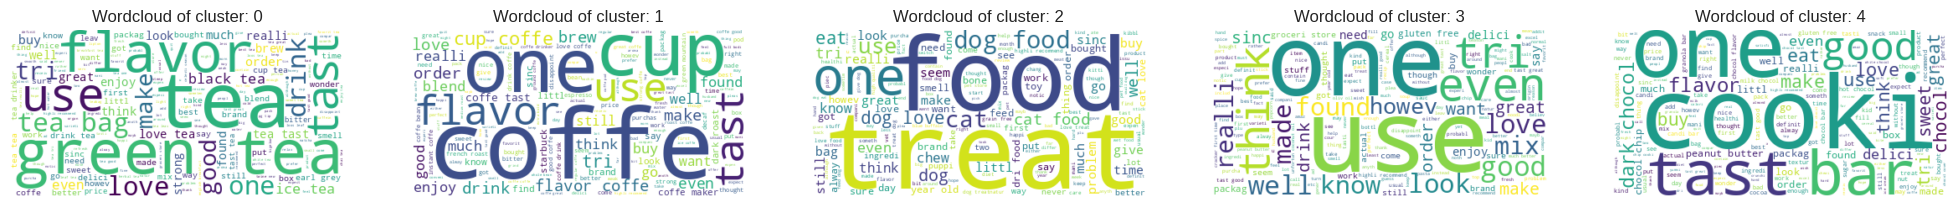

In [89]:
# Visualizing clusters and the contained words
cluster_wordclouds([X_train_c, kmeans.labels_], kmeans.n_clusters, ncols = 5)

## K-Means with Optimal k
We will now try to find the optimal number of clusters to perform k-means, through the Elbow method.
We do so on a sample of 7000 reviews, as performing it on the entire set would be computanionally expensive.

We therefore aim to find clusters according to their context.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

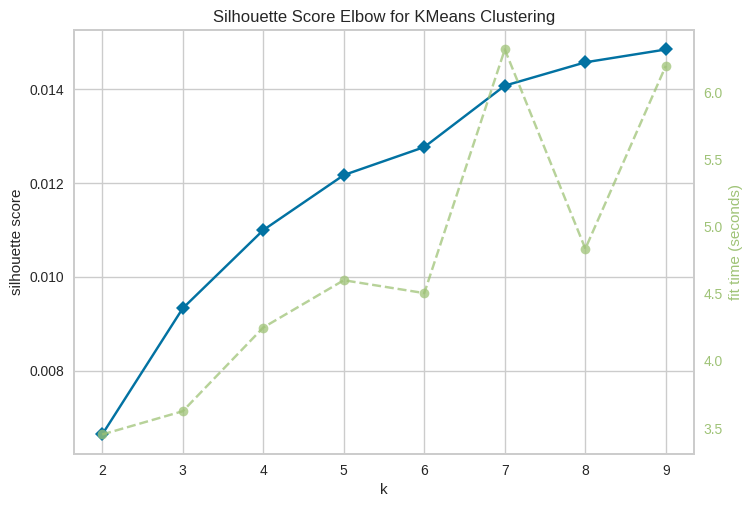

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
modelc = KMeans()
visualizer_ch = KElbowVisualizer(
    modelc, k=(2,10), metric='silhouette', locate_elbow = False
)

visualizer_ch.fit(X_stand_train[:7000])
visualizer_ch.show()

From the above graph it is possible to see that the optimal number of clusters might be between 8, as the silhouette score is near its maximum while the fit time is moderate.

Given this result, we will now try to perform the K-Means algorithm with k=9.

In [91]:
kmeans9 = KMeans(n_clusters=9, random_state=12345).fit(X_stand_train[:7000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [92]:
c9 = Counter(kmeans9.labels_)

for i in range(0, kmeans9.n_clusters, 1):
  print('N. of reviews in Cluster-' + str(i) + ': ' + str(c9[i]))

N. of reviews in Cluster-0: 903
N. of reviews in Cluster-1: 578
N. of reviews in Cluster-2: 2467
N. of reviews in Cluster-3: 1557
N. of reviews in Cluster-4: 310
N. of reviews in Cluster-5: 184
N. of reviews in Cluster-6: 464
N. of reviews in Cluster-7: 168
N. of reviews in Cluster-8: 369


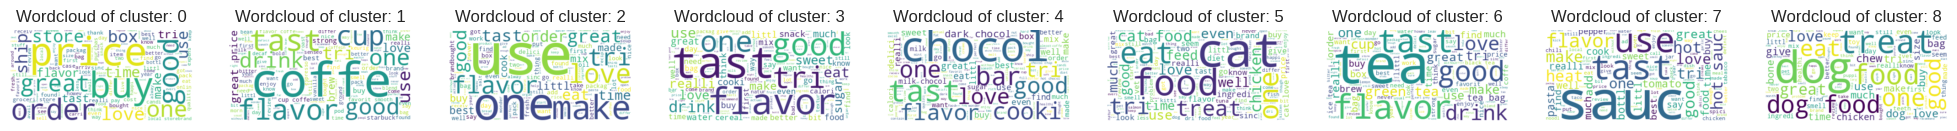

In [93]:
cluster_wordclouds([X_train_c[:7000], kmeans9.labels_], kmeans9.n_clusters, ncols = 9)

The word clouds for almost each cluster provide a clear picture of the predominant topics in the customer reviews. For instance, Cluster 1 appears to focus on reviews about coffee purchases, with words like “coffe”, “drink” and “good”, suggesting positive experiences related to buying coffee products. In Cluster 2, the common words “use” and “make” suggest that reviews in this group are about the preparation or usage of various products.

----------------------------------------------------------------------------
ReadMe file.

In [94]:
!pip freeze > requirements.txt

In [95]:
from google.colab import files

files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
readme_content = """
# Project Title

Supervised & Unsupervised Learning on Amazon Fine Food Reviews.

## Overview

This work was developed for the Text Mining & Search Exam. It consists in the application of text preprocessing and NLP techiniques to the Amazon Fine Food Reviews dataset.

## Dataset

The Dataset and can downloaded at the following link:
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

## Getting Started

The project was developed in Google Colab using Python.

## Prerequisites

The libraries and packages needed to run the project are listed in the requirements.txt file.

## Installation

To run this project in Colab, make sure to have downloaded and imported all packages and libraries listed in requirements.txt (this file is autogenerated by pip freeze).
The dataset must be uploaded in your Google Drive.

"""

with open("README.md", "w") as file:
    file.write(readme_content)


In [100]:
files.download('README.md')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>